# Предсказание перекрестных продаж страхования

**Цель:** - предсказать, какие клиенты положительно отреагируют на предложение по авто страхованию.

Данные взяты из kaggle-соревнования [Binary Classification of Insurance Cross Selling](https://www.kaggle.com/competitions/playground-series-s4e7/overview). 

Набор данных для этого соревнования (как обучающий, так и тестовый) был создан на основе набора данных продаж медицинского страхования [Health Insurance Cross Sell Prediction Data](https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data)

**Файлы**
- `train.csv` - обучающий набор данных
- `test.csv` - тестовый набор данных
- `sample_submission.csv` - образец файла для отправки в правильном формате

**Метрика:** ROC-AUC.

**Описание переменных**

- `id` -> Уникальный идентификатор клиента
- `Gender` -> Пол клиента
- `Age` -> Возраст клиента
- `Driving_License` ->0 : у клиента нет водительского удостоверение, 1 : у клиента есть
- `Region_Code` -> Уникальный код региона клиента
- `Previously_Insured` ->1 : У клиента уже есть страховка транспортного средства, 0: у клиента нет страховки транспортного средства
- `Vehicle_Age` -> Возраст автомобиля
- `Vehicle_Damage` -> 1 : У клиента в прошлом были повреждения транспортного средства. 0: У клиента в прошлом не было повреждений транспортного средства.
- `Annual_Premium` -> Сумма, которую клиент должен заплатить в качестве страховой премии в течение года
- `Policy_Sales_Channel` -> Анонимный код для канала связи с клиентом, т. е. разные агенты, по почте, по телефону, лично и т. д.
- `Vintage` -> Количество дней, в течение которых клиент был связан с компанией
- `Response` ->1 : Клиент заинтересован, 0: Клиент не заинтересован

**Цель** - Response

**План исследования**

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Feature Engineering
5. Обучение моделей
6. Описание проделанных попыток
7. Общий вывод

# Изучение данных
## Импорт библиотек

In [2]:
import os
import warnings
import gc

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold)
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import (
# OneHotEncoder OrdinalEncoder, LabelEncoder)
#from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

# Импортируем сторонние библиотеки
import phik
from phik.report import plot_correlation_matrix

#from optuna.integration import OptunaSearchCV
#from optuna import distributions
#from optuna.exceptions import ExperimentalWarning

from lightgbm import LGBMClassifier

import catboost as cb
from catboost import Pool

In [3]:
warnings.simplefilter('ignore', UserWarning)

## Функции

In [4]:
def test_shapiro(data, alpha):
    '''
    Функция проверяет данные на нормальное
    распределения, исполльзуя тест Шапиро-Уилка
    Принимает столбец и сверяет его p-value с уровнем
    статистической значимости и выводит ответ о нормальности

    '''

    statistic, p = st.shapiro(data)

    if p > alpha:
        print('Не отвергаем HO. \
Данные получены из нормального распределения')
    else:
        print('Отвергаем HO и принимаем H1. \
Данные не получены из нормального распределения')

## Константы

In [5]:
ALPHA = 0.05  # Задаем уровень значимости

TEST_SIZE = 0.25  # Задаем константу разделения датасета

RANDOM_STATE = 42  # Задаем константу для деления датасета на одинаковые выборки

## Загрузка данных

Прочитаем файлы `train.csv` и `test.csv` и сохраним их в соотвествующие переменные `train_df` и `test_df`

In [6]:
pth1 = r"C:\Users\stepa\Downloads\train.csv"
pth2 = r"C:\Users\stepa\Downloads\test.csv"

In [7]:
if os.path.exists(pth1):
    train_df = pd.read_csv(pth1)
else:
    print('Ошибка')

In [8]:
if os.path.exists(pth2):
    test_df = pd.read_csv(pth2)
else:
    print('Ошибка')

Выведем первые 5 строк всех таблиц

In [9]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [10]:
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


Посмотрим на общую информацию о данных в таблицах.

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [12]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


Рассмотрим полученную информацию подробнее.

Всего в таблице 12 столбцов, тип данных - `int`(6), `object`(3), `float`(3). Исходя из описательной статистики видно, что значения медианы и среднего в некоторых столбцах отличается, что, возможно, говорит о выбросах в данных.

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7669866 entries, 0 to 7669865
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 643.7+ MB


In [14]:
test_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06
mean,1.533973e+07,3.839137e+01,9.980208e-01,2.642661e+01,4.630772e-01,3.046553e+04,1.123650e+02,1.638996e+02
std,2.214100e+06,1.499951e+01,4.444387e-02,1.299433e+01,4.986349e-01,1.644586e+04,5.407358e+01,7.998445e+01
min,1.150480e+07,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01
25%,1.342226e+07,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.528000e+04,2.900000e+01,9.900000e+01
50%,1.533973e+07,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182700e+04,1.510000e+02,1.660000e+02
75%,1.725720e+07,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.946000e+04,1.520000e+02,2.320000e+02
max,1.917466e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02


Рассмотрим полученную информацию подробнее.

Всего в таблице 11 столбцов, тип данных - `int`(5), `object`(3), `float`(3). Исходя из описательной статистики видно, что значения медианы и среднего в некоторых столбцах отличается, что, возможно, говорит о выбросах в данных.

## Вывод

Каждая строка таблиц содержит информацию о клиенте. Необходимо сделать проверку данных:

- Проверить данные на наличие пропусков и заполнить их или удалить, если они не очень критичны.
- Сделать проверку на явные и неявные дубликаты и исправить их, если они будут найдены.
- Изменить типы данных для эффективного управления памятью

# Предобработка данных
## Изменение типов данных

Так как у нас очень много значений, важно использовать эффективно память компьютера. Для этого изменим типы данных.

In [15]:
train_df['Gender'] = train_df['Gender'].astype('category')
train_df['Vehicle_Age'] = train_df['Vehicle_Age'].astype('category')
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].astype('category')
train_df['Age'] = train_df['Age'].astype('int8')
train_df['Driving_License'] = train_df['Driving_License'].astype('int8')
train_df['Region_Code'] = train_df['Region_Code'].astype('int8')
train_df['Previously_Insured'] = train_df['Previously_Insured'].astype('int8')
train_df['Annual_Premium'] = train_df['Annual_Premium'].astype('int32')
train_df['Policy_Sales_Channel'] = train_df['Policy_Sales_Channel'].astype(
    'int32')
train_df['Vintage'] = train_df['Vintage'].astype('int32')
train_df['Response'] = train_df['Response'].astype('int8')

И тоже самое сделаем для тестового датасета

In [16]:
test_df['Gender'] = test_df['Gender'].astype('category')
test_df['Vehicle_Age'] = test_df['Vehicle_Age'].astype('category')
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].astype('category')
test_df['Age'] = test_df['Age'].astype('int8')
test_df['Driving_License'] = test_df['Driving_License'].astype('int8')
test_df['Region_Code'] = test_df['Region_Code'].astype('int8')
test_df['Previously_Insured'] = test_df['Previously_Insured'].astype('int8')
test_df['Annual_Premium'] = test_df['Annual_Premium'].astype('int32')
test_df['Policy_Sales_Channel'] = test_df['Policy_Sales_Channel'].astype(
    'int32')
test_df['Vintage'] = test_df['Vintage'].astype('int32')

## Работа с пропусками

Проверим наличие пропусков в датафреймах и их долю от общего числа

In [24]:
count_na_train = pd.Series(train_df.isna().sum(), name='Пропуски')

In [25]:
proportion_na_train = pd.Series(
    (train_df.isna().sum() / len(train_df)).round(4) * 100, name='Доля')

In [26]:
pd.concat([count_na_train, proportion_na_train],
          axis=1).sort_values(by='Доля', ascending=False)

,Пропуски,Доля
id,0,0.0
Gender,0,0.0
Age,0,0.0
Driving_License,0,0.0
Region_Code,0,0.0
Previously_Insured,0,0.0
Vehicle_Age,0,0.0
Vehicle_Damage,0,0.0
Annual_Premium,0,0.0
Policy_Sales_Channel,0,0.0


В таблице с обучающимся набором данных пропусков не обнаружено

In [27]:
count_na_test = pd.Series(test_df.isna().sum(), name='Пропуски')

In [28]:
proportion_na_test = pd.Series(
    (test_df.isna().sum() / len(test_df)).round(4) * 100, name='Доля')

In [29]:
pd.concat([count_na_test, proportion_na_test],
          axis=1).sort_values(by='Доля', ascending=False)

,Пропуски,Доля
id,0,0.0
Gender,0,0.0
Age,0,0.0
Driving_License,0,0.0
Region_Code,0,0.0
Previously_Insured,0,0.0
Vehicle_Age,0,0.0
Vehicle_Damage,0,0.0
Annual_Premium,0,0.0
Policy_Sales_Channel,0,0.0


В таблице с тестовыми данными пропусков не обнаружено

## Работа с явными дубликатами

Проверим имеющиеся датасеты на наличие явных дубликатов.

In [30]:
train_df.duplicated().sum()  # Считаем количество дубликатов

0

In [31]:
test_df.duplicated().sum()  # Считаем количество дубликатов

0

Ни в одном датасете дубликатов не обнаружено

## Работа с неявными дубликатами

Проверим столбцы `Gender`, `Vehicle_Age`, `Vehicle_Damage` и `Region_Code` на наличие неявных дубликатов. Возможно в этих столбцах одно и то же значение написано с разным регистром или же есть лишние пробелы. Также одно и то же значение может быть написано по-разному.

Начнем с тренировочного набора.

In [17]:
# Выводим количество уникальных значений
gender_tn = train_df['Gender'].value_counts()
gender_tn

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

In [18]:
# Выводим количество уникальных значений
vehicle_age_tn = train_df['Vehicle_Age'].value_counts()
vehicle_age_tn

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

In [19]:
# Выводим количество уникальных значений
vehicle_damage_tn = train_df['Vehicle_Damage'].value_counts()
vehicle_damage_tn

Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64

In [20]:
# Выводим количество уникальных значений
region_code_tn = train_df['Region_Code'].value_counts()
region_code_tn

Region_Code
28    3451062
8     1021036
46     578208
41     557581
15     403977
30     367307
29     338146
50     302334
11     278261
36     261946
3      246303
33     232387
47     229190
35     200035
6      181122
45     159292
37     158976
18     148548
39     138069
14     134585
21     126793
10     126081
2      118097
48     114230
13     108838
9       93371
7       92240
12      92142
27      78878
32      78797
43      75868
17      74533
26      71228
25      70556
24      69136
38      60587
0       59274
20      58765
31      58442
16      54905
23      54518
4       52504
49      50822
34      48685
19      44197
22      36932
5       36832
40      35888
1       33966
44      20305
42      13693
52       3450
51       1880
Name: count, dtype: int64

Теперь проверим тестовые данные.

In [21]:
# Выводим количество уникальных значений
gender_ts = test_df['Gender'].value_counts()
gender_ts

Gender
Male      4151402
Female    3518464
Name: count, dtype: int64

In [22]:
# Выводим количество уникальных значений
vehicle_age_ts = test_df['Vehicle_Age'].value_counts()
vehicle_age_ts

Vehicle_Age
1-2 Year     3989276
< 1 Year     3361255
> 2 Years     319335
Name: count, dtype: int64

In [23]:
# Выводим количество уникальных значений
vehicle_damage_ts = test_df['Vehicle_Damage'].value_counts()
vehicle_damage_ts

Vehicle_Damage
Yes    3854463
No     3815403
Name: count, dtype: int64

In [24]:
# Выводим количество уникальных значений
region_code_ts = test_df['Region_Code'].value_counts()
region_code_ts

Region_Code
28    2299652
8      681778
46     386147
41     372203
15     268477
30     244864
29     224596
50     201968
11     184821
36     174967
3      164427
33     155735
47     152803
35     133825
6      120975
45     105868
37     105620
18      99023
39      91993
14      90023
21      84503
10      83607
2       78461
48      76381
13      72542
9       62304
7       61745
12      61717
32      52787
27      52315
43      50970
17      49492
26      47810
25      46793
24      46316
38      40562
0       39320
31      39143
20      38648
16      36905
23      36176
4       34954
49      34036
34      32328
19      29253
22      24443
5       24220
40      23831
1       22359
44      13583
42       9042
52       2295
51       1260
Name: count, dtype: int64

## Вывод

На данном этапе были сделаны следующие действия:

- Сделали проверку на пропуски в данных. В результате пропуски не были найдены.
- Сделали проверку на явные дубликаты. В результате они не были обнаружены.
- Сделали проверку на неявные дубликаты в столбцах `Gender`, `Vehicle_Age`, `Vehicle_Damage` и `Region_Code`. В результате они не были обнаружены.
- Изменили типы данных для эффективного управления памятью

# Исследовательский анализ данных

Исследуем данные в датафрейме `train_df`:

- Посмотрим на соотношение целевого признака - `Response`
- Посмотрим на соотношение остальных категориальных данных - `Gender`, `Driving_License`, `Previously_Insured`, `Vehicle_Age`, `Vehicle_Damage`.
- Изучим количественные переменные: `Age`, `Annual_Premium`, `Policy_Sales_Channel` и `Vintage` в зависимости от таргета.

Для тестового набора данных проводить анализ не будем, так как этот набор данных является выборкой из тренировочного, а следовательно, имеет такие же свойства, как и у тренировочного, так как выборка репрезентативна.

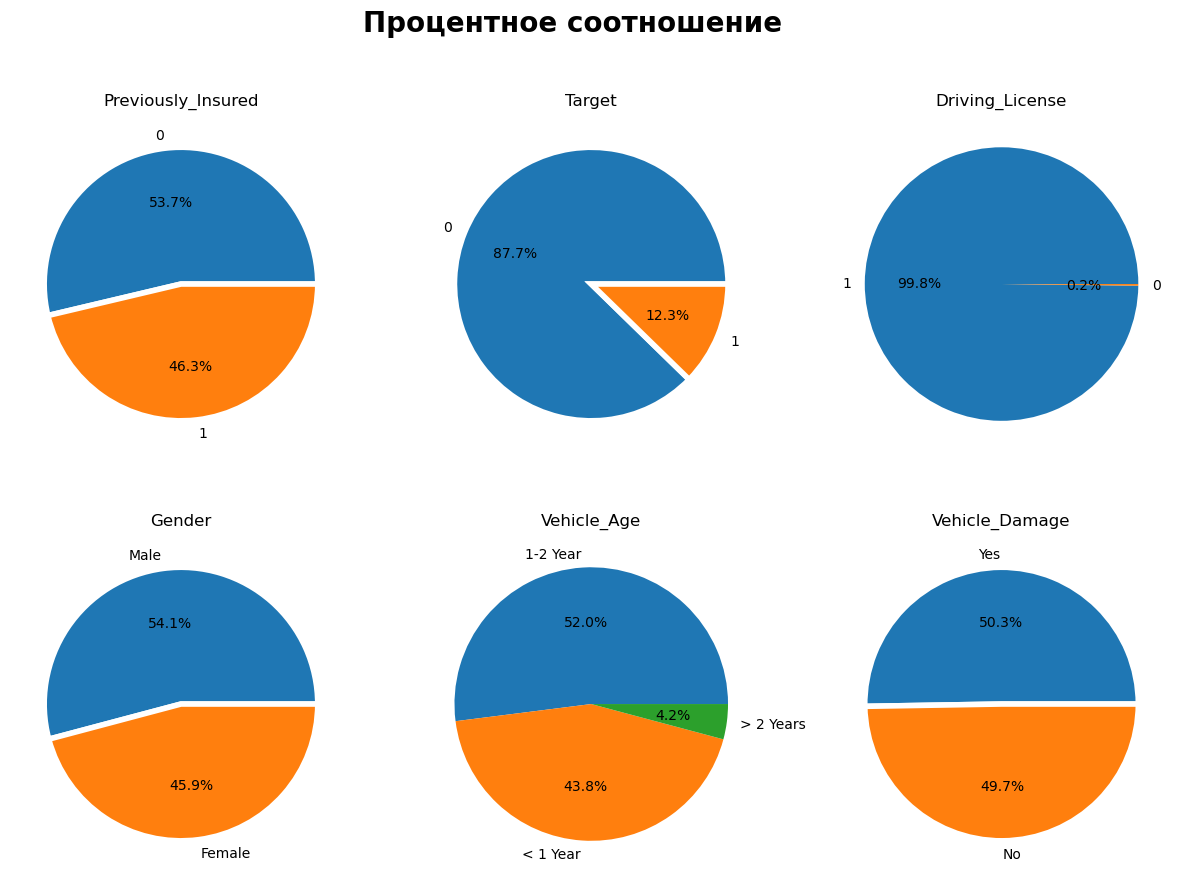

In [25]:
plt.figure(figsize=(15, 10))

plt.suptitle('Процентное соотношение', fontsize=20, fontweight='bold')

plt.subplot(2, 3, 1)
plt.pie(train_df['Previously_Insured'].value_counts().values,
        labels=train_df['Previously_Insured'].value_counts().index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Previously_Insured')

plt.subplot(2, 3, 2)
plt.pie(train_df['Response'].value_counts().values,
        labels=train_df['Response'].value_counts().index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Target')

plt.subplot(2, 3, 3)
plt.pie(train_df['Driving_License'].value_counts().values,
        labels=train_df['Driving_License'].value_counts().index,
        autopct='%.1f%%')
plt.title('Driving_License')

plt.subplot(2, 3, 4)
plt.pie(gender_tn.values,
        labels=gender_tn.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Gender')

plt.subplot(2, 3, 5)
plt.pie(vehicle_age_tn.values,
        labels=vehicle_age_tn.index,
        autopct='%.1f%%')
plt.title('Vehicle_Age')

plt.subplot(2, 3, 6)
plt.pie(vehicle_damage_tn.values,
        labels=vehicle_damage_tn.index,
        wedgeprops={'linewidth': 4, 'edgecolor': 'white'},
        autopct='%.1f%%')
plt.title('Vehicle_Damage');

Только 12.3% клиентов положительно отнесутся к предложению об авто страховании.

Практически по каждому признаку одинаковое соотношение значений:
- `Gender`, 54.1% против 45.9%
- `Previously_Insured`, 53.7% против 46.3%
- `Vehicle_Damage`, 50.3% против 49.7%

Исключение составляют `Driving_License`, что и логично, что у клиента должно быть водительское удостоверение, чтобы получить авто страхование. `Vehicle_Age` здесь машины старше двух лет являются меньшинством 4.2%

Теперь приступим к изучению количественных данных и сначала построим диаграмму размаха.

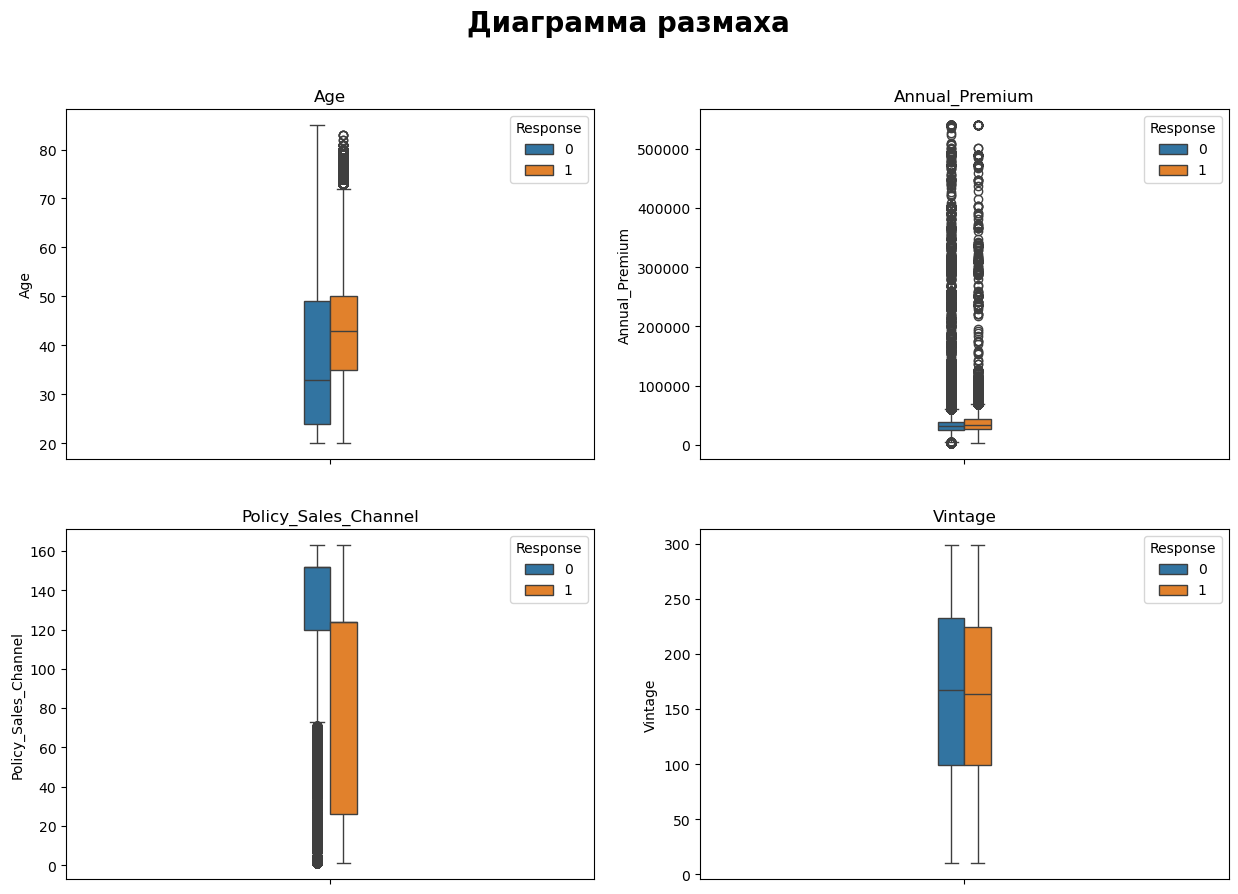

In [33]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(y='Age', hue='Response', data=train_df, width=.1)
sns.color_palette()
plt.title('Age')

plt.subplot(2, 2, 2)
sns.boxplot(y='Annual_Premium', hue='Response',
            data=train_df, width=.1)
sns.color_palette()
plt.title('Annual_Premium')

plt.subplot(2, 2, 3)
sns.boxplot(y='Policy_Sales_Channel', hue='Response',
            data=train_df, width=.1)
sns.color_palette()
plt.title('Policy_Sales_Channel')

plt.subplot(2, 2, 4)
sns.boxplot(y='Vintage', hue='Response', data=train_df, width=.1)
sns.color_palette()
plt.title('Vintage');

Видно, что у признака `Annual_Premium` очень много выбивающиеся значения на графике `boxplot`. Необходимо более подробно изучить эти данные, чтобы понять, являются ли эти значения выбросами, но перед этим построим гистограммы распределений.

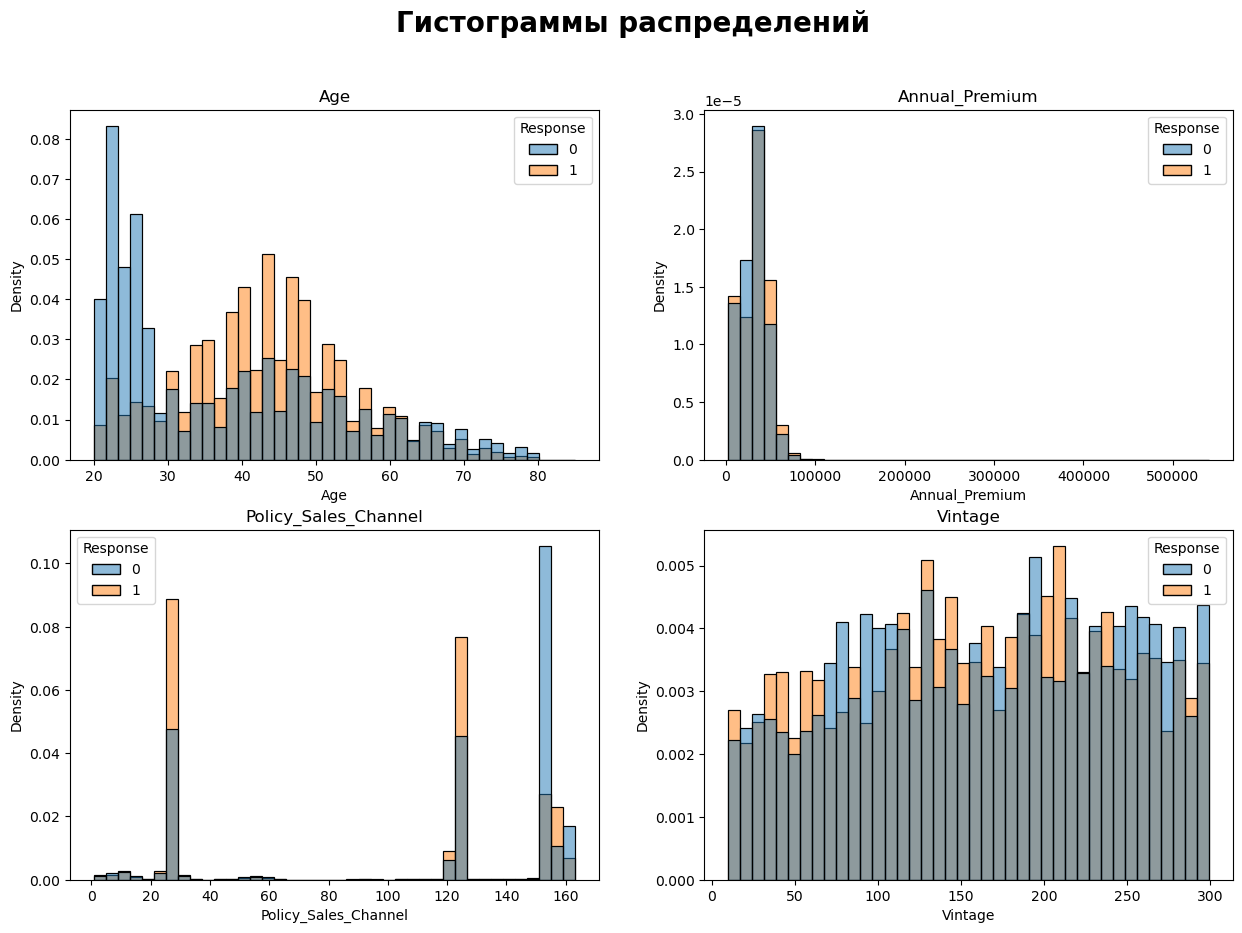

In [32]:
plt.figure(figsize=(15, 10))

plt.suptitle('Гистограммы распределений', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(data=train_df, x='Age', bins=40, hue='Response',
             stat='density', common_norm=False)
plt.title('Age')

plt.subplot(2, 2, 2)
sns.histplot(data=train_df, x='Annual_Premium', bins=40,
             hue='Response', stat='density', common_norm=False)
plt.title('Annual_Premium')

plt.subplot(2, 2, 3)
sns.histplot(data=train_df, x='Policy_Sales_Channel', bins=40,
             hue='Response', stat='density', common_norm=False)
plt.title('Policy_Sales_Channel')

plt.subplot(2, 2, 4)
sns.histplot(data=train_df, x='Vintage', bins=40,
             hue='Response', stat='density', common_norm=False)
plt.title('Vintage');

Видно, что данные распределены ненормально, чтобы точно быть уверенным в этом, проведем статистический тест Шапиро-Уилка. Также стоит обратить внимание на `Annual_Premium` распределение этого признака имеет длинный хвост, скорее всего сильно выбивающиеся значения составляют малую часть.

Перед тем как использовать тест Шапиро-Уилка необходимо сформулировать гипотезы.
- **H0** - данные получены из нормального распределения
- **H1** - данные не получены из нормального распределения

Предположим, что верна нулевая гипотеза, тогда

In [43]:
test_shapiro(train_df['Age'], ALPHA)

Отвергаем HO и принимаем H1. Данные не получены из нормального распределения


In [44]:
test_shapiro(train_df['Annual_Premium'], ALPHA)

Отвергаем HO и принимаем H1. Данные не получены из нормального распределения


In [45]:
test_shapiro(train_df['Policy_Sales_Channel'], ALPHA)

Отвергаем HO и принимаем H1. Данные не получены из нормального распределения


In [46]:
test_shapiro(train_df['Vintage'], ALPHA)

Отвергаем HO и принимаем H1. Данные не получены из нормального распределения


Как и ожидалось все данные имеют не нормальное распределение.

In [40]:
#train_df[train_df['Annual_Premium'] > 100000]

In [41]:
#(len(train_df[train_df['Annual_Premium'] > 100000]) / len(train_df['Annual_Premium'])) * 100

Таких значений всего 2307 и они составляют всего 0.02% от общего числа.

In [34]:
#train_df = train_df[train_df['Annual_Premium'] < 100000]

## Вывод

На данном этапе были получены следующие результаты:
1. Узнали соотношение целевого признака `Response`: 87.7% - `0` и 12.3% - `1`
2. Узнали соотношение остальных категориальных данных - `Gender`, `Driving_License`, `Previously_Insured`, `Vehicle_Age`, `Vehicle_Damage`. У большинства признаков значения имеют одинаковое соотношение. Выделяется только столбец `Driving_License` - 99.8 у `1`, что и логично, что у клиента должно быть водительское удостоверение, чтобы получить авто страхование.
3. Проверили количественные признаки на выбросы. Были выделяющиеся значения в столбце `Annual_Premium`. В целом такие значения возможны, так как сумму, которую необходимо заплатить клиенту зависит от разных факторов.
4. Проверили наши данные на нормальность. Все количественные признаки имеют ненормальное распределение.

# Корреляционный анализ

Приступим к корреляционному анализу. Так как на предыдущем этапе мы выяснили, что данные у нас распределены ненормально, то для расчета корреляции воспользуемся корреляцией $\phi_k$. Сосчитаем  ее при помощи библиотеки phik для всех наших признаков. Так как значений в датасетах много, воспользуемся функцией `sample` для создания репрезентативной выборки.

In [44]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_train = train_df.drop(columns='id', axis=1).sample(50000).phik_matrix(interval_cols=[
    'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'])

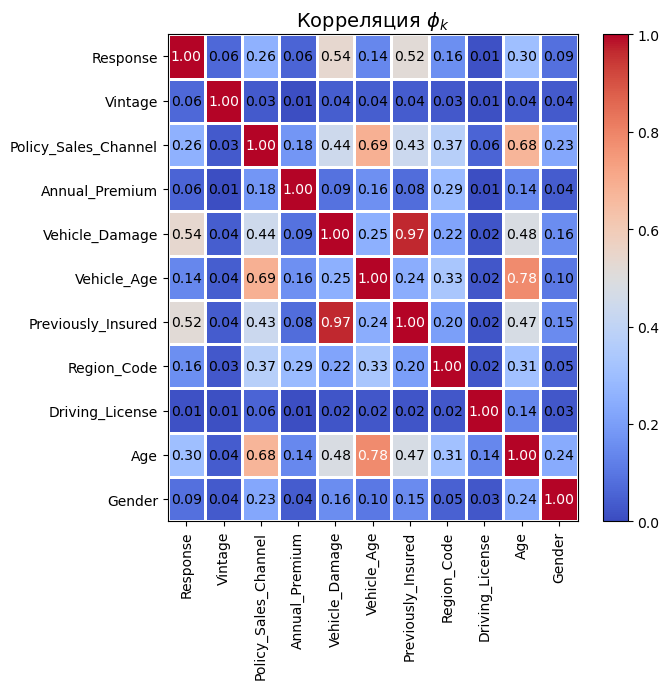

In [45]:
plot_correlation_matrix(phik_matrix_train.values, x_labels=phik_matrix_train.columns, y_labels=phik_matrix_train.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(7, 7))

plt.tight_layout()

Наш целевой признак `Response`. 

У него отсутствует взаимосвязь с `Driving_Licinse` и `Annual_Premium` - 0.00 и 0.03. Также очень слабая взаимосвязь с `Vintage` и `Gender` - 0.07 и 0.07. 
Есть взаимосвязь с `Vehicle_Damage` и `Previously_Insured` - 0.54 и 0.52. 

Также можно заметить, что в данных присутствует мультиколлинеарность между `Vehicle_Damage` и `Previously_Insured`. 

Заметная взаимосвязь между `Policy_Sales_Channel` и `Vehicle_Age`/ `Age` 0.70 и 0.68 соответственно.

*Так как в дальнейшем решил отказаться от Логистической регрессии и использовать только Градиентный бустинг, то избавляться от мультиколлинеарности нет необходимости, а следовательно удалять столбец `Previously_Insured` не будем*

*Также после некоторых попыток стало понятно, что удалять столбцы `Driving_License` и `Annual_Premium` не стоит, хоть они и не вносят никого вклада. (результаты модели становились хуже)*

In [10]:
#train_df_del = train_df.drop(columns=['Previously_Insured', 'Driving_License', 'Annual_Premium'])

In [47]:
#phik_matrix_train = train_df_del.drop(columns=['id'], axis=1).sample(50000).phik_matrix(
    #interval_cols=['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage'])

In [38]:
#plot_correlation_matrix(phik_matrix_train.values, x_labels=phik_matrix_train.columns, y_labels=phik_matrix_train.index,
                        #vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        #figsize=(7, 7))

#plt.tight_layout()

Теперь проделаем посмотрим на взаимосвязь в тестовом датасете.

In [49]:
# Расчитываем коэффициент корреляции Фи
phik_matrix_test = test_df.drop(columns='id', axis=1).sample(50000).phik_matrix(
    interval_cols=['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'])

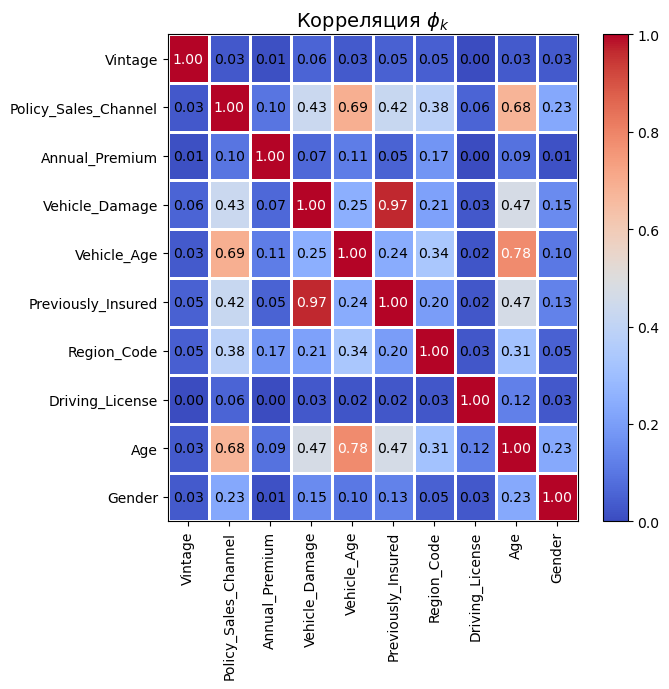

In [50]:
plot_correlation_matrix(phik_matrix_test.values, x_labels=phik_matrix_test.columns, y_labels=phik_matrix_test.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(7, 7))

plt.tight_layout()

Результаты аналогичные, как и ожидалось.

In [11]:
#test_df_del = test_df.drop(columns=['Previously_Insured', 'Driving_License', 'Annual_Premium'])

In [52]:
#phik_matrix_test = test_df_del.drop(columns=['id'], axis=1).sample(50000).phik_matrix(
    #interval_cols=['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage'])

In [37]:
#plot_correlation_matrix(phik_matrix_test.values, x_labels=phik_matrix_test.columns, y_labels=phik_matrix_test.index,
                        #vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        #figsize=(7, 7))

#plt.tight_layout()

# Feature Engineering

Попробуем создать новые признаки. Но сначала заменим категориальные данные более удобным способом

In [9]:
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].replace(
    {'No':  0, 'Yes': 1})

train_df['Gender'] = train_df['Gender'].replace(
    {'Male': 0, 'Female': 1})

train_df['Vehicle_Age'] = train_df['Vehicle_Age'].replace(
    {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

In [10]:
test_df['Vehicle_Damage'] = test_df['Vehicle_Damage'].replace(
    {'No':  0, 'Yes': 1})

test_df['Gender'] = test_df['Gender'].replace({'Male': 0, 'Female': 1})

test_df['Vehicle_Age'] = test_df['Vehicle_Age'].replace(
    {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

Создадим столбец `Not_Insured_and_Damaged`, чтобы выделить клиентов без страховки и повреждений.

In [11]:
train_df['Not_Insured_and_Damaged'] = train_df['Vehicle_Damage'].astype(
    'int8') * (1-train_df['Previously_Insured'])
test_df['Not_Insured_and_Damaged'] = test_df['Vehicle_Damage'].astype(
    'int8') * (1-test_df['Previously_Insured'])

Так как в корреляционном анализе была заметна мультиколлинеарность. Обратимся к столбцу `Previously_Insured` и на его основе создадим новые столбцы. Для этого мы переведем данный столбец в тип данных `str` и прибавим к нему другие столбцы при этом воспользуемся функцией `pd.factorize` для кодировки новых значений.

In [12]:
train_df['Previously_Insured_Annual_Premium'] = pd.factorize(
    (train_df['Previously_Insured'].astype('str') + train_df['Annual_Premium'].astype('str')).to_numpy())[0]

train_df['Previously_Insured_Vehicle_Age'] = pd.factorize(
    (train_df['Previously_Insured'].astype('str') + train_df['Vehicle_Age'].astype('str')).to_numpy())[0]

train_df['Previously_Insured_Vehicle_Damage'] = pd.factorize(
    (train_df['Previously_Insured'].astype('str') + train_df['Vehicle_Damage'].astype('str')).to_numpy())[0]

train_df['Previously_Insured_Vintage'] = pd.factorize(
    (train_df['Previously_Insured'].astype('str') + train_df['Vintage'].astype('str')).to_numpy())[0]

Тоже самое делаем для тестового набора

In [13]:
test_df['Previously_Insured_Annual_Premium'] = pd.factorize(
    (test_df['Previously_Insured'].astype('str') + test_df['Annual_Premium'].astype('str')).to_numpy())[0]

test_df['Previously_Insured_Vehicle_Age'] = pd.factorize(
    (test_df['Previously_Insured'].astype('str') + test_df['Vehicle_Age'].astype('str')).to_numpy())[0]

test_df['Previously_Insured_Vehicle_Damage'] = pd.factorize(
    (test_df['Previously_Insured'].astype('str') + test_df['Vehicle_Damage'].astype('str')).to_numpy())[0]

test_df['Previously_Insured_Vintage'] = pd.factorize(
    (test_df['Previously_Insured'].astype('str') + test_df['Vintage'].astype('str')).to_numpy())[0]

Изменим тип данных новых столбцов для эффективного управления памятью

In [14]:
train_df['Previously_Insured_Annual_Premium'] = train_df['Previously_Insured_Annual_Premium'].astype(
    'int32')
train_df['Previously_Insured_Vehicle_Age'] = train_df['Previously_Insured_Vehicle_Age'].astype(
    'int8')
train_df['Previously_Insured_Vehicle_Damage'] = train_df['Previously_Insured_Vehicle_Damage'].astype(
    'int8')
train_df['Previously_Insured_Vintage'] = train_df['Previously_Insured_Vintage'].astype(
    'int32')

In [15]:
test_df['Previously_Insured_Annual_Premium'] = test_df['Previously_Insured_Annual_Premium'].astype(
    'int32')
test_df['Previously_Insured_Vehicle_Age'] = test_df['Previously_Insured_Vehicle_Age'].astype(
    'int8')
test_df['Previously_Insured_Vehicle_Damage'] = test_df['Previously_Insured_Vehicle_Damage'].astype(
    'int8')
test_df['Previously_Insured_Vintage'] = test_df['Previously_Insured_Vintage'].astype(
    'int32')

Сделаем стндартизацию для числовых признаков. Для этого воспользуемся `StandardScaler()`

In [35]:
train_copy = train_df.copy()
test_copy = test_df.copy()

In [16]:
# Создаём список с количественными признаками
num_columns = ['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage',
               'Annual_Premium', 'Previously_Insured_Annual_Premium', 'Previously_Insured_Vintage']

In [17]:
scaler = StandardScaler()

train_df[num_columns] = scaler.fit_transform(train_df[num_columns])
test_df[num_columns] = scaler.transform(test_df[num_columns])

После стандартизации также изменит тип данных

In [18]:
train_df['Age'] = train_df['Age'].astype('float32')
train_df['Region_Code'] = train_df['Region_Code'].astype('float32')
train_df['Annual_Premium'] = train_df['Annual_Premium'].astype('float32')
train_df['Policy_Sales_Channel'] = train_df['Policy_Sales_Channel'].astype(
    'float32')
train_df['Vintage'] = train_df['Vintage'].astype('float32')
train_df['Previously_Insured_Annual_Premium'] = train_df['Previously_Insured_Annual_Premium'].astype(
    'float32')
train_df['Previously_Insured_Vintage'] = train_df['Previously_Insured_Vintage'].astype(
    'float32')

In [19]:
test_df['Age'] = test_df['Age'].astype('float32')
test_df['Region_Code'] = test_df['Region_Code'].astype('float32')
test_df['Annual_Premium'] = test_df['Annual_Premium'].astype('float32')
test_df['Policy_Sales_Channel'] = test_df['Policy_Sales_Channel'].astype(
    'float32')
test_df['Vintage'] = test_df['Vintage'].astype('float32')
test_df['Previously_Insured_Annual_Premium'] = test_df['Previously_Insured_Annual_Premium'].astype(
    'float32')
test_df['Previously_Insured_Vintage'] = test_df['Previously_Insured_Vintage'].astype(
    'float32')

Выведим первые 5 строк финального датафрейма и информацию о нем

In [23]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Not_Insured_and_Damaged,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage
0,0,0,-1.159410,1,0.660528,0,1,1,2.105145,0.214202,0.288852,0,1,-0.929348,0,0,-1.624320
1,1,0,0.307897,1,0.121718,0,2,1,1.728962,-1.599414,1.551675,1,1,-0.929292,1,0,-1.618162
2,2,1,-0.892627,1,-0.955902,1,0,0,0.460756,0.732378,1.126567,0,0,-0.929236,2,1,-1.612004
3,3,1,-0.225669,1,-1.956550,0,1,1,-1.691389,0.806403,-1.099003,0,1,-0.929181,0,0,-1.605846
4,4,1,-0.158974,1,-0.878929,1,1,0,0.090529,0.732378,1.626694,0,0,-0.929125,3,1,-1.599688


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 17 columns):
 #   Column                             Dtype   
---  ------                             -----   
 0   id                                 int64   
 1   Gender                             category
 2   Age                                float32 
 3   Driving_License                    int8    
 4   Region_Code                        float32 
 5   Previously_Insured                 int8    
 6   Vehicle_Age                        category
 7   Vehicle_Damage                     category
 8   Annual_Premium                     float32 
 9   Policy_Sales_Channel               float32 
 10  Vintage                            float32 
 11  Response                           int8    
 12  Not_Insured_and_Damaged            int8    
 13  Previously_Insured_Annual_Premium  float32 
 14  Previously_Insured_Vehicle_Age     int8    
 15  Previously_Insured_Vehicle_Damage  int8    
 16

Теперь можно приступать к обучению модели.

# Обучение моделей

Приступим к обучению модели. Перед нами стоит задача бинарной классификации и нам необходимо предсказать наш целевой признак `Response`.

Будем использовать `LGBMClassifier` совместно с `RandomizdeSearchCV` для подбора гиперпараметров.

Оценивать модель будем по метрике `ROC_AUC`. Также после обучения модели, проверим ее на адекватность при помощи `DummyClassifier`.

Данные уже подготовлены поэтому можем приступать к обучению. Подготовим тренировочную выборку.

*В первых попытках использовалась `LogisticRegression` совместно с `OptunaSearchCV` для подбора параметров. Подготовка признаков для обучения проводилась в пайплайне.*

In [20]:
X = train_df.drop(columns=['id', 'Response'], axis=1)
y = train_df['Response']

X_test = test_df.drop(columns='id')

In [26]:
# Разделяем данные на тренировочные и валидационные
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

Посмотрим на размеры выборок, чтобы убедиться, что все разбиение прошло правильно

In [27]:
X_train.shape, y_train.shape

((8628598, 15), (8628598,))

In [28]:
X_valid.shape, y_valid.shape

((2876200, 15), (2876200,))

## Логистическая регрессия 

In [60]:
# Инициализируем модель логистической регрессии
#model_lr = LogisticRegression(random_state=RANDOM_STATE)

In [61]:
# Создаём словарь со значениями гиперпараметров для перебора в optuna
#parameters_opt_lr = {
    #'penalty': distributions.CategoricalDistribution(['l1', 'l2']),
    #'C': distributions.CategoricalDistribution(choices=(0.01, 0.1, 1, 10, 100, 1000)),
    #'solver': distributions.CategoricalDistribution(['liblinear', 'saga'])}

In [36]:
# Инициализируем OptunaSearchCV
#optuna_lr = OptunaSearchCV(
    #model_lr,
    #parameters_opt_lr,
    #cv=5,
    #scoring='roc_auc',
    #n_jobs=-1,
    #random_state=RANDOM_STATE,
    #n_trials=10,
    #refit=True)

#optuna_lr.fit(X_train_p, y_train_p)

#print('Лучшая модель и её параметры:\n\n', optuna_lr.best_estimator_)
#print(f'Метрика ROC-AUC на кросс-валидации: {optuna_lr.best_score_:.2f}')
#print(
    #f'Отклонение метрики на кросс-валидации: {pd.DataFrame(optuna_lr.cv_results_)["std_test_score"].mean():.2%}')

## LGBM

Воспользуемся градиентным бустингом `LGBMRegressor` с фиксированными параметрами `lambda_l1` = 3 и `learning_rate` = 0.075. Параметры этой модели будем подбирать с помощью `RandomizedSearchCV()`:

- `num_leaves`
- `n_estimators`
- `min_child_samples`
- `max_depth`

In [21]:
# Инициализируем модель
lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, 
    n_jobs=-1, 
    lambda_l1=3, 
    learning_rate=0.075, 
    objective='binary',
    verbosity=-1)

In [22]:
# Создаём словарь со значениями гиперпараметров для перебора
parameters_lgbm = {
    'num_leaves': [50, 100, 130],
    'n_estimators': [1000, 1500, 2000],
    'max_depth': range(2, 10),
    'min_child_samples': [30, 50]
}

In [23]:
# Инициализируем класс для случайного поиска
randomized_search_lgbm = RandomizedSearchCV(
    lgbm,
    parameters_lgbm,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [24]:
randomized_search_lgbm.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(lambda_l1=3, learning_rate=0.075,
                                            n_jobs=-1, objective='binary',
                                            random_state=42, verbosity=-1),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 10),
                                        'min_child_samples': [30, 50],
                                        'n_estimators': [1000, 1500, 2000],
                                        'num_leaves': [50, 100, 130]},
                   random_state=42, scoring='roc_auc')

3ч 50мин 31сек

In [25]:
print('Лучшая модель и её параметры:\n\n',
      randomized_search_lgbm.best_estimator_)

print(f'Метрика ROC-AUC на кросс-валидации: \
{randomized_search_lgbm.best_score_:.2f}')

print(f'Отклонение метрики на кросс-валидации: \
{pd.DataFrame(randomized_search_lgbm.cv_results_)["std_test_score"].mean():.2f}')

Лучшая модель и её параметры:

 LGBMClassifier(lambda_l1=3, learning_rate=0.075, max_depth=7,
               min_child_samples=30, n_estimators=2000, n_jobs=-1,
               num_leaves=100, objective='binary', random_state=42,
               verbosity=-1)
Метрика ROC-AUC на кросс-валидации: 0.89
Отклонение метрики на кросс-валидации: 0.00


In [40]:
y_pred_val = randomized_search_lgbm.predict_proba(X_valid)

print(
    f'Метрика ROC-AUC на валидационной выборке: {roc_auc_score(y_valid, y_pred_val[:,1]):.2f}')

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
Метрика ROC-AUC на валидационной выборке: 0.89


In [41]:
del X_train, y_train
del X_valid, y_valid
del X, y
del train_df, test_df
gc.collect()

5653

## CatBoost

В дальнейшем в обсуждениях соревнования утверждали, что `CatBoost` сработает лучше (первое место по итогу занял именно он). Я пытался воспользоваться им совместно с `StratifiedKFold` с 5ью фолдами, но к сожалению, расчет длился слишком долго (больше 10ч) и от этой идеи я отказался.

In [37]:
#X = train_copy.drop(columns=['id', 'Response'], axis=1)
#y = train_copy['Response']

#X_test = test_copy.drop(columns='id')

In [38]:
#FOLDS = 5

In [ ]:
#skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

#X = X.reset_index(drop=True)
#y = y.reset_index(drop=True)

#scores = []
#best_score = 0

#for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    #print(f"# Fold {fold + 1}")
    #X_train_fold = X.loc[train_idx]
    #y_train_fold = y.loc[train_idx].values
    #X_val_fold = X.loc[val_idx]
    #y_val_fold = y.loc[val_idx].values
    #X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    #X_val_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
    #X_test_pool = Pool(X_test, cat_features=X_test.columns.values)

    # Обучаем CatBoost
    #model = cb.CatBoostClassifier(
        #loss_function='Logloss',
        #eval_metric='AUC',
        #class_names=[0, 1],
        #learning_rate=0.075,
        #iterations=5000,
        #depth=9,
        #random_strength=0,
        #l2_leaf_reg=0.5,
        #max_leaves=512,
        #fold_permutation_block=64,
        #random_seed=42,
        #verbose=False)

    #model.fit(X=X_train_pool,
              #eval_set=X_val_pool,
              #verbose=500,
              #early_stopping_rounds=200)

    #score = model.best_score_['validation']['AUC']
    #print('Fold ROC-AUC score: ', score)
    #scores.append(score)

    #if score > best_score:
        #best_score = score

    #del X_train_fold, y_train_fold
    #del X_val_fold, y_val_fold
    #del X_train_pool, X_val_pool, X_test_pool
    #del model
    #gc.collect()

#print('Среднеяя ROC-AUC score: ', sum(scores) / FOLDS)
#print('Лучшая метрика ROC-AUC: ', best_score)

## Проверка моделей на адекватность

Проверим модели на адекватность, сравнив качество предсказаний с качеством модели, которая предсказывала бы константу.

Для этого воспользуемся `DummyClassifier`. Главное, чтобы ее показания были хуже, чем у обученных нами моделей.

In [35]:
model_dc = DummyClassifier(strategy='most_frequent')
model_dc.fit(X_train, y_train)

y_pred_dc = model_dc.predict_proba(X_valid)

print(
    f'Метрика ROC-AUC на дамми моделе: {roc_auc_score(y_valid, y_pred_dc[:,1])}')

Метрика ROC-AUC на дамми моделе: 0.5


Модель прошла проверку на адекватность

# Предсказания на тестовой

Сделаем предсказания на тестовой выборке и сделаем таблицу, в которой будет содержаться только название и статус стартапа. Названия компаний находятся в отдельном файле, в начале необходимо его загрузить.

In [26]:
pth3 = r"C:\Users\stepa\Downloads\sample_submission.csv"

In [27]:
if os.path.exists(pth3):
    predict = pd.read_csv(pth3)
else:
    print('Ошибка')

In [32]:
y_test_pred = randomized_search_lgbm.predict_proba(X_test)

In [33]:
predict['Response'] = y_test_pred[:,1]

In [34]:
predict['id'] = predict['id'].astype('int32')
predict['Response'] = predict['Response'].astype('float32')

In [35]:
# Сохраняем предсказания в файл
predict.to_csv('predict_bin.csv', index=False)

# Описание  проделанных попыток

Краткое описание некоторых проделанных попыток:
1. В первой попытке были удалены столбцы `Previously_Insured` (из-за мультиколлинеарности), `Driving_License`, `Annual_Premium`. И обучена регрессия 0.086936
2. Далее решил воспользоваться бустингом `LGBM`. Он показал себя лучше 0.87833
3. В третей попытке удалили столбец `vintage` результат стал хуже. 0.87830
4. Далее решил обратить внимание на столбец `Annual_Premium` и на его выбивающиеся значения. Значения после 100000 очень редкие их всего 2307 и они составляли всего 0.02% от общего числа. Я решил удалить эти значения. Результат стал хуже. 0.87819
5. Была попытка, в которой я решил не удалять столбцы, которые не вносят никакого вклада. Результат стал лучше 0.87851. Поэтому решил отказаться от логистической регрессии, так как на ее работу может повлиять мультиколлинеарность, а для бустинга она не так важна.
6. В следующих попытках пытался воспользоваться сэмплингом в виде `SMOTENC`, так как по исследовательскому анализу видно, что значения таргета неодинаковое. (Не оправдала надежд)
7. Пробовал полиномиальное преобразование признаков. Результат стал хуже
8. Добавил множество новых столбцов.
9. Отказался от пайплайна, так как необходимость в нем пропала.
10. В последних попытках решил воспользоваться `CatBoost` совместно с `StratifiedKFold`. Был слишком долгий расчет. Пришлось оставить эту идею.

# Общий вывод

Данные были получены из:

- `train.csv`
- `test.csv`
- `sample_submission.csv`

В начале изучили данные. Все исследование проходило в 6 этапов.

1. Изучение данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Feature Engineering
5. Обучение моделей
6. Описание проделанных попыток
7. Общий вывод

Перед нами стояла задача прогноза. Оценить успешность ее выполнения требовалось по метрике `ROC-AUC`.

**1. Изученние данных**

Тренировочный набор данных сохранили в переменной `train_df`, а тестовый в `test_df`.

Всего в `train_df` 12 столбцов, тип данных - `int`(6), `object`(3), `float`(3). 

Всего в `test_df` 11 столбцов, тип данных - `int`(5), `object`(3), `float`(3). 

Далее исходя из описательной статистики заметили, что значения медианы и среднего в некоторых столбцах отличается, что, возможно, говорило о выбросах в данных.

**2. Предобработка данных**

После изучения данных приступили к их обработке. Так как данных очень много, то изменили типы данных для эффективного управления памятью.

Сделали проверку на пропуски в данных. В результате пропуски не были найдены.

Сделали проверку на явные дубликаты. В результате они не были обнаружены.

Сделали проверку на неявные дубликаты в столбцах `Gender`, `Vehicle_Age`, `Vehicle_Damage` и `Region_Code`. В результате они не были обнаружены.

**3. Исследовательских анализ данных**

В ходе исследовательского анализа необходимо было изучить распределение данных. А также выяснить соотношение целевого признака
`Response`

- 87.7% - `0` и 12.3% - `1`

Узнали соотношение остальных категориальных данных - `Gender`, `Driving_License`, `Previously_Insured`, `Vehicle_Age`, `Vehicle_Damage`. У большинства признаков значения имеют одинаковое соотношение. Выделяется только столбец `Driving_License` - 99.8 у `1`, что и логично, что у клиента должно быть водительское удостоверение, чтобы получить авто страхование.

Проверили количественные признаки на выбросы. Было много выделяющихся значений в столбце `Annual_Premium`. В целом такие значения возможны, так как сумму, которую необходимо заплатить клиенту зависит от разных факторов.

Проверили наши данные на нормальность при помощи статистического теста Шапиро-Уилка. Все количественные признаки имеют ненормальное распределение.

**4. Корреляционный анализ**

После анализа признаков можно приступать к исследованию взаимосвязи между ними. Так как мы выяснили, что данные у нас распределены ненормально, то для расчета корреляции воспользовались корреляцией 𝜙𝑘 из библиотеки `phik` для всех наших признаков. Так как значений в датасетах много, воспользовались функцией `sample` для создания репрезентативной выборки.

В данных мы заметили, что присутствует мультиколлинеарность между `Vehicle_Damage` и `Previously_Insured`. Но в дальнейшем решил отказаться от Логистической регрессии и использовать только Градиентный бустинг, то избавляться от мультиколлинеарности нет необходимости.

*После некоторых попыток стало понятно, что удалять столбцы `Driving_License` и `Annual_Premium` не стоит, хоть они и не вносят никого вклада. (результаты модели стали лучше)*

**5. Feature Engineering**

В дальнейшем стало понятно, что, чтобы улучшить метрику, необходимо создать новые признаки. Создали столбец `Not_Insured_and_Damaged`, чтобы выделить клиентов без страховки и повреждений. Так как в корреляционном анализе заметили мультиколлинеарность. Обратился к столбцу `Previously_Insured` и на его основе создал новые столбцы. Для этого перевел данный столбец в тип данных `str` и прибавим к нему другие столбцы при этом воспользовался функцией `pd.factorize` для кодировки новых значений.

По итогу добавил 5 новых столбцов. И перед тем как перейти к обучению моделей. Сделал стандартизацию для числовых признаков с помощью `StandardScaler()`

**6. Обучение моделей**

Приступил к обучению модели. Перед нами стояла задача бинарной классификации и нам необходимо предсказать наш целевой признак `Response`.

По итогу использовал `LGBMClassifier` совместно с `RandomizdeSearchCV` для подбора гиперпараметров.

Оценивал модель по метрике `ROC_AUC`. Также после обучения модели, проверим ее на адекватность при помощи `DummyClassifier`.

*В первых попытках использовалась `LogisticRegression` совместно с `OptunaSearchCV` для подбора параметров. Подготовка признаков для обучения проводилась в пайплайне.*

В результате получил метрику 0.89 на тренировочной выборке. На тестовой выборке - 0.878.

**Вывод**

В результате проекта была разработана модель, которая может предсказывать согласиться ли клиент на предложение об авто страховании. Была достигнута хорошее значение метрики благодаря feature engineering и использования LGBM модели.

Дальнейший проект можно улучшить используя CatBoost совместно с StratifiedKFold.